In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import numpy as np
import theano

import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

from scipy.special import expit
from scipy.stats import logistic

from theano import tensor as T
from theano.tensor.shared_randomstreams import RandomStreams
from theano.printing import debugprint

from lasagne.updates import adam
from lasagne.utils import floatX
from lasagne.nonlinearities import sigmoid
from lasagne.layers import get_output, get_all_params
from lasagne.layers import (InputLayer,
                            DenseLayer,
                            NonlinearityLayer)


from matplotlib.animation import FuncAnimation
from IPython.display import HTML, SVG, display_html
from tqdm import tnrange, tqdm_notebook

/home/tiao/.virtualenvs/implicit/lib/python3.5/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [3]:
# display animation inline
plt.rc('animation', html='html5')
plt.style.use('seaborn-notebook')
sns.set_context('notebook')

In [4]:
np.set_printoptions(precision=2,
                    edgeitems=3,
                    linewidth=80,
                    suppress=True)

In [5]:
LATENT_DIM = 2
NOISE_DIM = 3
BATCH_SIZE = 200
PRIOR_VARIANCE = 2.
LEARNING_RATE = 3e-3
PRETRAIN_EPOCHS = 60

In [6]:
w_min, w_max = -5, 5

In [7]:
w1, w2 = np.mgrid[w_min:w_max:300j, w_min:w_max:300j]

In [8]:
w_grid = np.dstack((w1, w2))
w_grid.shape

(300, 300, 2)

In [9]:
log_prior = -.5*np.sum(w_grid**2, axis=2)/PRIOR_VARIANCE
log_prior.shape

(300, 300)

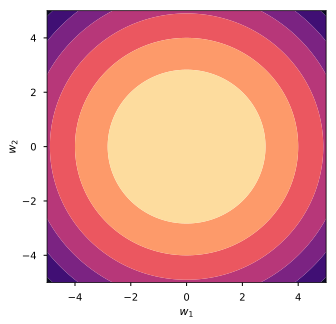

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.contourf(w1, w2, log_prior, cmap='magma')

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

plt.show()

In [11]:
x1 = np.array([ 1.5,  1.])
x2 = np.array([-1.5,  1.])
x3 = np.array([  .5, -1.])

In [12]:
X = np.vstack((x1, x2, x3))
X.shape

(3, 2)

In [13]:
y1 = 1
y2 = 1
y3 = -1

In [14]:
y = np.stack((y1, y2, y3))
y.shape

(3,)

In [15]:
def log_likelihood(w, x, y):
    # equiv. to negative binary cross entropy
    return logistic.logcdf(y*(np.dot(w.T,x)))

In [16]:
llhs = log_likelihood(w_grid.T, X.T, y)
llhs.shape

(300, 300, 3)

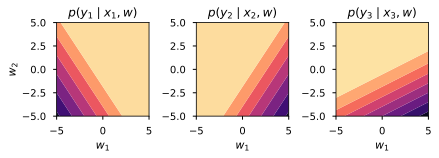

In [17]:
fig, axes = plt.subplots(ncols=3, figsize=(6, 2))
fig.tight_layout()

for i, ax in enumerate(axes):
    
    ax.contourf(w1, w2, llhs[::,::,i], cmap=plt.cm.magma)

    ax.set_xlim(w_min, w_max)
    ax.set_ylim(w_min, w_max)
    
    ax.set_title('$p(y_{{{0}}} \mid x_{{{0}}}, w)$'.format(i+1))
    ax.set_xlabel('$w_1$')    
    
    if not i:
        ax.set_ylabel('$w_2$')

plt.show()

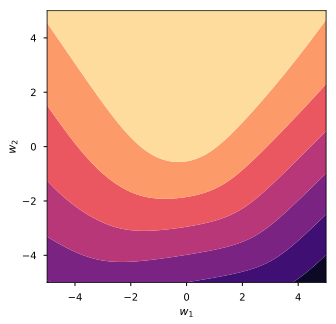

In [18]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.contourf(w1, w2, np.sum(llhs, axis=2), cmap='magma')

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

plt.show()

In [19]:
# unnormalised log posterior
# only for illustration purposes
log_post = log_prior + np.sum(llhs, axis=2)

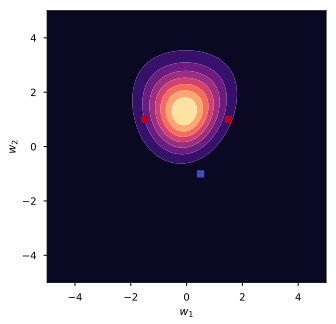

In [20]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.contourf(w1, w2, np.exp(log_post), cmap='magma')
ax.scatter(*X.T, c=y, cmap='coolwarm', marker=',')

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

plt.show()

## Fitting an approximate posterior

This part is for the actual GAN stuff. Here we define the generator and the discriminator networks in Lasagne, and code up the two loss functions in theano.

In [21]:
#defines a 'generator' network
def build_G(input_var=None, num_z = 3):
    
    network = InputLayer(input_var=input_var, shape=(None, num_z))
    
    network = DenseLayer(incoming = network, num_units=10)
    
    network = DenseLayer(incoming = network, num_units=20)
    
    network = DenseLayer(incoming = network, num_units=2, nonlinearity=None)
    
    return network

In [22]:
#defines the 'discriminator network'
def build_D(input_var=None):

    network = InputLayer(input_var=input_var, shape = (None, 2))
    
    network = DenseLayer(incoming = network, num_units=10)
    
    network = DenseLayer(incoming = network, num_units=20)
    
    network = DenseLayer(incoming = network, num_units=1, nonlinearity=None)
    
    normalised = NonlinearityLayer(incoming = network, nonlinearity = sigmoid)
    
    return { 'unnorm':network, 'norm':normalised }

In [23]:
#variables for input (design matrix), output labels, GAN noise variable, weights
x_var = T.matrix('design matrix')
y_var = T.vector('labels')
z_var = T.matrix('GAN noise')
w_var = T.matrix('weights')

#theano variables for things like batchsize, learning rate, etc.
batchsize_var = T.scalar('batchsize', dtype='int32')
prior_variance_var = T.scalar('prior variance')
learningrate_var = T.scalar('learning rate')

#random numbers for sampling from the prior or from the GAN
srng = RandomStreams(seed=13574437)
z_rnd = srng.normal((batchsize_var,3))
prior_rnd = srng.normal((batchsize_var,2))

#instantiating the G and D networks
generator = build_G(z_var)
discriminator = build_D()

#these expressions are random samples from the generator and the prior, respectively
samples_from_grenerator = get_output(generator, z_rnd)
samples_from_prior = prior_rnd*T.sqrt(prior_variance_var)

#discriminator output for synthetic samples, both normalised and unnormalised (after/before sigmoid)
D_of_G = get_output(discriminator['norm'], inputs=samples_from_grenerator)
s_of_G = get_output(discriminator['unnorm'], inputs=samples_from_grenerator)

#discriminator output for real samples from the prior
D_of_prior = get_output(discriminator['norm'], inputs=samples_from_prior)

#loss of discriminator - simple binary cross-entropy loss
loss_D = -T.log(D_of_G).mean() - T.log(1-D_of_prior).mean()

#log likelihood for each synthetic w sampled from the generator
log_likelihood = T.log(
    T.nnet.sigmoid(
        (y_var.dimshuffle(0,'x','x')*(x_var.dimshuffle(0,1,'x') * samples_from_grenerator.dimshuffle('x', 1, 0))).sum(1)
    )
).sum(0).mean()

#loss for G is the sum of unnormalised discriminator output and the negative log likelihood
loss_G = s_of_G.mean() - log_likelihood

#compiling theano functions:
evaluate_generator = theano.function(
    [z_var],
    get_output(generator),
    allow_input_downcast=True
)

sample_generator = theano.function(
    [batchsize_var],
    samples_from_grenerator,
    allow_input_downcast=True,
)

sample_prior = theano.function(
    [prior_variance_var, batchsize_var],
    samples_from_prior,
    allow_input_downcast=True
)

params_D = get_all_params(discriminator['norm'], trainable=True)

updates_D = adam(
    loss_D,
    params_D,
    learning_rate = learningrate_var
)

train_D = theano.function(
    [learningrate_var, batchsize_var, prior_variance_var],
    loss_D,
    updates = updates_D,
    allow_input_downcast = True
)

params_G = get_all_params(generator, trainable=True)

updates_G = adam(
    loss_G,
    params_G,
    learning_rate = learningrate_var
)

train_G = theano.function(
    [x_var, y_var, learningrate_var, batchsize_var],
    loss_G,
    updates = updates_G,
    allow_input_downcast = True
)

evaluate_discriminator = theano.function(
    [w_var],
    get_output([discriminator['unnorm'],discriminator['norm']],w_var),
    allow_input_downcast = True
)

#this is to evaluate the log-likelihood of an arbitrary set of w
llh_for_w = T.nnet.sigmoid((y_var.dimshuffle(0,'x','x')*(x_var.dimshuffle(0,1,'x') * w_var.dimshuffle('x', 1, 0))).sum(1))

evaluate_loglikelihood = theano.function(
        [x_var, y_var, w_var],
        llh_for_w,
        allow_input_downcast = True
    )

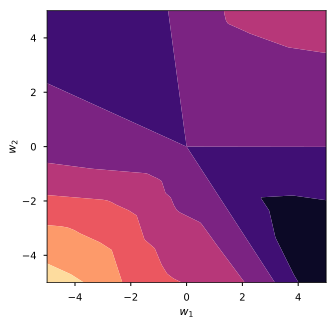

In [24]:
fig, ax = plt.subplots(figsize=(5, 5))

w_grid_ratio, _ = evaluate_discriminator(w_grid.reshape(300*300, 2))
w_grid_ratio = w_grid_ratio.reshape(300,300)

ax.contourf(w1, w2, w_grid_ratio, cmap='magma')

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

plt.show()

In [25]:
w_sample_prior = sample_prior(PRIOR_VARIANCE, BATCH_SIZE)
w_sample_posterior = sample_generator(BATCH_SIZE)

In [26]:
inputs = np.vstack((w_sample_prior, w_sample_posterior))
targets = np.hstack((np.zeros(BATCH_SIZE), np.ones(BATCH_SIZE)))

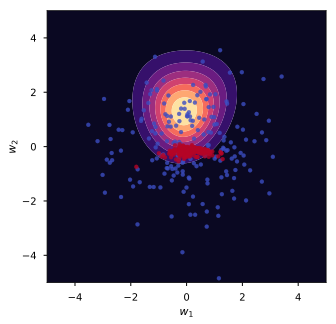

In [27]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.contourf(w1, w2, np.exp(log_post), cmap='magma')

ax.scatter(*inputs.T, c=targets, s=4.**2, alpha=.8, cmap='coolwarm')

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

plt.show()

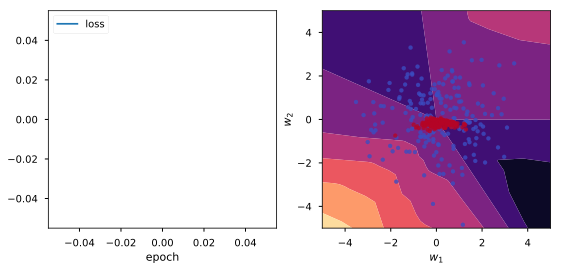

In [28]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

loss_plot, = ax1.plot([], label='loss')

ax1.set_xlabel('epoch')
ax1.legend(loc='upper left')

ax2.contourf(w1, w2, w_grid_ratio, cmap='magma')
ax2.scatter(*inputs.T, c=targets, s=4.**2, alpha=.8, cmap='coolwarm')

ax2.set_xlabel('$w_1$')
ax2.set_ylabel('$w_2$')

ax2.set_xlim(w_min, w_max)
ax2.set_ylim(w_min, w_max)

plt.show()

In [29]:
def train_animate(epoch_num, prog_bar, batch_size=200, steps_per_epoch=15):

    # Single training epoch
    
    for step in tnrange(steps_per_epoch, unit='step', leave=False):
        
        loss = np.asscalar(train_D(LEARNING_RATE, 
                                   batch_size, 
                                   PRIOR_VARIANCE))
    
    w_sample_prior = sample_prior(PRIOR_VARIANCE, batch_size)
    w_sample_posterior = sample_generator(batch_size)

    inputs = np.vstack((w_sample_prior, w_sample_posterior))
    targets = np.hstack((np.zeros(batch_size), np.ones(batch_size)))    
    
    w_grid_ratio, _ = evaluate_discriminator(w_grid.reshape(300*300, 2))
    w_grid_ratio = w_grid_ratio.reshape(300,300)
    
    # Plot Loss

    loss_plot.set_xdata(np.append(loss_plot.get_xdata(), epoch_num))    
    loss_plot.set_ydata(np.append(loss_plot.get_ydata(), loss))
    loss_plot.set_label('loss ({:.2f})'.format(loss))
    
    ax1.set_xlabel('epoch {:2d}'.format(epoch_num))
    ax1.legend(loc='upper left')

    ax1.relim()
    ax1.autoscale_view()
    
    # Contour Plot
    
    ax2.cla()
    
    ax2.contourf(w1, w2, w_grid_ratio, cmap='magma')
    ax2.scatter(*inputs.T, c=targets, s=4.**2, alpha=.8, cmap='coolwarm')

    ax2.set_xlabel('$w_1$')
    ax2.set_ylabel('$w_2$')

    ax2.set_xlim(w_min, w_max)
    ax2.set_ylim(w_min, w_max)
    
    # Progress Bar Updates
    
    prog_bar.update()
    prog_bar.set_postfix(loss=loss)

    return loss_plot,

In [30]:
# main training loop is managed by higher-order
# FuncAnimation which makes calls to an `animate` 
# function that encapsulates the logic of single
# training epoch. Has benefit of producing 
# animation but can incur significant overhead
with tqdm_notebook(total=PRETRAIN_EPOCHS, 
                   unit='epoch', leave=True) as prog_bar:

    anim = FuncAnimation(fig, 
                         train_animate,
                         fargs=(prog_bar,),
                         frames=PRETRAIN_EPOCHS,
                         interval=200, # 5 fps
                         blit=True)

    anim_html5_video = anim.to_html5_video()

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


In [31]:
HTML(anim_html5_video)

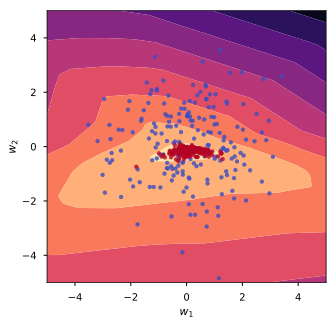

In [32]:
fig, ax = plt.subplots(figsize=(5, 5))

w_grid_ratio, _ = evaluate_discriminator(w_grid.reshape(300*300, 2))
w_grid_ratio = w_grid_ratio.reshape(300,300)

ax.contourf(w1, w2, w_grid_ratio, cmap='magma')

ax.scatter(*inputs.T, c=targets, s=4.**2, alpha=.8, cmap='coolwarm')

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

plt.show()

### Adversarial Training

In [33]:
llh_theano = evaluate_loglikelihood(X, y, w_grid.reshape(300*300, 2))
llh_theano.shape

(3, 90000)

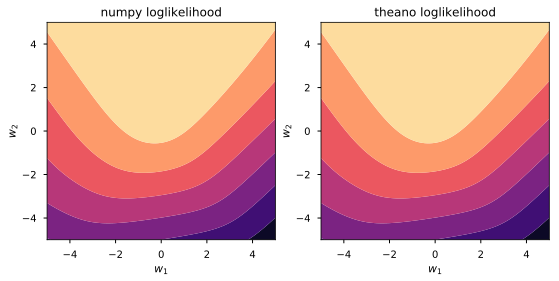

In [34]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(9, 4))

ax1.contourf(w1, w2, np.sum(llhs, axis=2), 
             cmap='magma')

ax1.set_xlabel('$w_1$')
ax1.set_ylabel('$w_2$')

ax1.set_xlim(w_min, w_max)
ax1.set_ylim(w_min, w_max)
ax1.set_title('numpy loglikelihood')

ax2.contourf(w1, w2, np.sum(np.log(llh_theano), 0).reshape(300,300), 
             cmap='magma')

ax2.set_xlabel('$w_1$')
ax2.set_ylabel('$w_2$')

ax2.set_xlim(w_min, w_max)
ax2.set_ylim(w_min, w_max)
ax2.set_title('theano loglikelihood')

plt.show()

In [35]:
np.allclose(np.sum(llhs, axis=2),
            np.sum(np.log(llh_theano), 0).reshape(300,300))

True

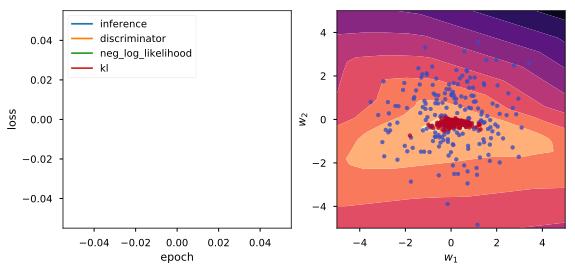

In [36]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

global_epoch = 0

plots_dict = {k:ax1.plot([], label=k)[0] for k in ('inference', 
                                                   'discriminator', 
                                                   'neg_log_likelihood',
                                                   'kl')}

ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.legend(loc='upper left')

ax2.contourf(w1, w2, w_grid_ratio, cmap='magma')
ax2.scatter(*inputs.T, c=targets, s=4.**2, alpha=.8, cmap='coolwarm')

ax2.set_xlabel('$w_1$')
ax2.set_ylabel('$w_2$')

ax2.set_xlim(w_min, w_max)
ax2.set_ylim(w_min, w_max)

plt.show()

In [37]:
def train_animate(epoch_num, prog_bar, batch_size=200, 
                  steps_per_epoch=15):

    global global_epoch, plots_dict

    plot_values = defaultdict(int)
    
    # Single training epoch

    ## Ratio estimator training

    for _ in tnrange(150, unit='step', desc='discriminator', 
                     leave=False):

        plot_values['discriminator'] = np.asscalar(train_D(LEARNING_RATE, 
                                                           batch_size, 
                                                           PRIOR_VARIANCE))
    
    ## Inference model training

    for _ in tnrange(1, unit='step', desc='inference', leave=False):

        np.asscalar(train_G(X, y, LEARNING_RATE, batch_size))

    global_epoch += 1

    w_sample_prior = sample_prior(PRIOR_VARIANCE, batch_size)
    w_sample_posterior = sample_generator(batch_size)

    inputs = np.vstack((w_sample_prior, w_sample_posterior))
    targets = np.hstack((np.zeros(batch_size), np.ones(batch_size)))

    plot_values['kl'] = np.mean(evaluate_discriminator(w_sample_posterior)[0])
    plot_values['neg_log_likelihood'] = -np.mean(np.sum(np.log(evaluate_loglikelihood(X, y, w_sample_posterior)), axis=0))
    
    plot_values['inference'] = plot_values['kl'] + plot_values['neg_log_likelihood']

    w_grid_ratio, _ = evaluate_discriminator(w_grid.reshape(300*300, 2))
    w_grid_ratio = w_grid_ratio.reshape(300,300)
    
    # Plot Loss

    for k in plots_dict:

        plots_dict[k].set_xdata(np.append(plots_dict[k].get_xdata(), global_epoch))
        plots_dict[k].set_ydata(np.append(plots_dict[k].get_ydata(), plot_values[k]))
        plots_dict[k].set_label('{} ({:.2f})'.format(k, plot_values[k]))

    ax1.set_xlabel('epoch {:2d}'.format(global_epoch))
    ax1.legend(loc='upper left')
    
    ax1.relim()
    ax1.autoscale_view()
    
    # Contour Plot
    
    ax2.cla()

    ax2.contourf(w1, w2, w_grid_ratio, cmap='magma')
    ax2.scatter(*inputs.T, c=targets, s=4.**2, alpha=.8, cmap='coolwarm')

    ax2.set_xlabel('$w_1$')
    ax2.set_ylabel('$w_2$')

    ax2.set_xlim(w_min, w_max)
    ax2.set_ylim(w_min, w_max)

    # Progress Bar Updates
    
    prog_bar.update()
#     prog_bar.set_postfix(loss_g=loss_g, loss_d=loss_d)

    return list(plots_dict.values())

In [38]:
with tqdm_notebook(total=50, 
                   unit='epoch', leave=True) as prog_bar:

    anim = FuncAnimation(fig, 
                         train_animate,
                         fargs=(prog_bar,),
                         frames=50,
                         interval=200, # 5 fps
                         blit=True)
    
    anim_html5_video = anim.to_html5_video()
    
HTML(anim_html5_video)

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


In [39]:
with tqdm_notebook(total=50, 
                   unit='epoch', leave=True) as prog_bar:

    anim = FuncAnimation(fig, 
                         train_animate,
                         fargs=(prog_bar,),
                         frames=50,
                         interval=200, # 5 fps
                         blit=True)
    
    anim_html5_video = anim.to_html5_video()
    
HTML(anim_html5_video)

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


In [40]:
with tqdm_notebook(total=50, 
                   unit='epoch', leave=True) as prog_bar:

    anim = FuncAnimation(fig, 
                         train_animate,
                         fargs=(prog_bar,),
                         frames=50,
                         interval=200, # 5 fps
                         blit=True)
    
    anim_html5_video = anim.to_html5_video()
    
HTML(anim_html5_video)

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


In [41]:
with tqdm_notebook(total=50, 
                   unit='epoch', leave=True) as prog_bar:

    anim = FuncAnimation(fig, 
                         train_animate,
                         fargs=(prog_bar,),
                         frames=50,
                         interval=200, # 5 fps
                         blit=True)
    
    anim_html5_video = anim.to_html5_video()
    
HTML(anim_html5_video)

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


In [42]:
w_grid_ratio, _ = evaluate_discriminator(w_grid.reshape(300*300, 2))
w_grid_ratio = w_grid_ratio.reshape(300,300)

In [43]:
w_sample_prior = sample_prior(PRIOR_VARIANCE, 100)
w_sample_posterior = sample_generator(100)

In [44]:
inputs = np.vstack((w_sample_prior, w_sample_posterior))
targets = np.hstack((np.zeros(100), np.ones(100)))

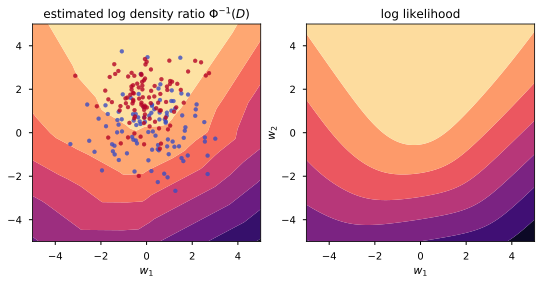

In [45]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(9, 4))

ax1.contourf(w1, w2, w_grid_ratio, cmap='magma')
ax1.scatter(*inputs.T, c=targets, s=4.**2, alpha=.8, cmap='coolwarm')

ax1.set_xlabel('$w_1$')

ax1.set_xlim(w_min, w_max)
ax1.set_ylim(w_min, w_max)

ax1.set_title('estimated log density ratio $\Phi^{-1}(D)$')

ax2.contourf(w1, w2, np.sum(llhs, axis=2), 
             cmap=plt.cm.magma)

ax2.set_xlabel('$w_1$')
ax2.set_ylabel('$w_2$')

ax2.set_xlim(w_min, w_max)
ax2.set_ylim(w_min, w_max)

ax2.set_title('log likelihood')

plt.show()

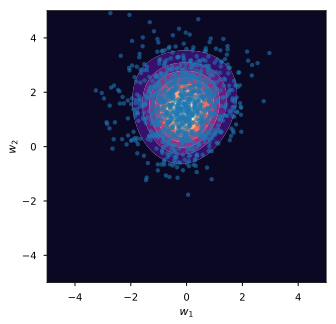

In [46]:
fig, ax = plt.subplots( figsize=(5, 5))

ax.contourf(w1, w2, 
            np.exp(log_post), 
            cmap=plt.cm.magma)

ax.scatter(*sample_generator(1000).T, 
            s=4.**2, alpha=.6, cmap='coolwarm_r')

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

plt.show()

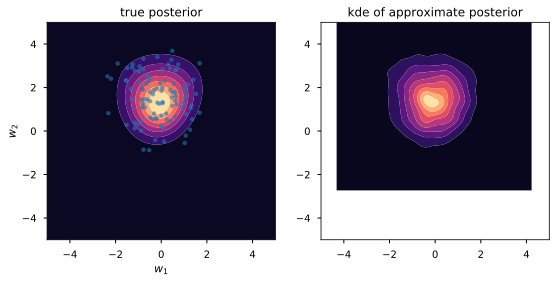

In [50]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(9, 4))

ax1.contourf(w1, w2, 
            np.exp(log_prior+np.sum(llhs, axis=2)), 
            cmap=plt.cm.magma)

ax1.scatter(*sample_generator(100).T, 
            s=4.**2, alpha=.6, cmap='coolwarm_r')

ax1.set_xlabel('$w_1$')
ax1.set_ylabel('$w_2$')

ax1.set_xlim(w_min, w_max)
ax1.set_ylim(w_min, w_max)

ax1.set_title('true posterior')

sns.kdeplot(*sample_generator(5000).T,
            shade=True, cmap='magma', ax=ax2)

ax2.set_xlim(w_min, w_max)
ax2.set_ylim(w_min, w_max)

ax2.set_title('kde of approximate posterior')

plt.show()